In [233]:
import os
import cv2
import numpy as np
from tqdm  import tqdm
np.random.seed(1)

REBUILD_DATA = False 

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "/home/username/Documents/PetImages/Cat"
    DOGS = "/home/username/Documents/PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0

    def make_training_data(self):
                for label in self.LABELS:   #iterating through directories
                    print(label)
                    for f in tqdm(os.listdir(label)): # iterating through images in directory
                
                            try:
                                path = os.path.join(label, f) #joinng label which is the path of the directory with f which is img file name
                                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #converting the path into grayscale, we ar doing this becasue we don't care about colors
                                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                                #print(np.eye(2)[self.LABELS[label]])

                                if label == self.CATS:
                                    self.catcount += 1
                                elif label == self.DOGS:
                                    self.dogcount += 1

                            except Exception as e:
                                pass  


                np.random.shuffle(self.training_data)     
                np.save("training_data.npy",self.training_data)
                print("Cats: ", self.catcount)
                print("Dog: ", self.dogcount)

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()
    
#There is two columns, one for the image array and second for the one_hot array. [1 0] is cat and [0 1] is dog

In [234]:
training_data = np.load("training_data.npy", allow_pickle= True) #we have assigned REBUILD_DATA as False after we generate training data

In [235]:
print(len(training_data)) #checking the lenght of training data 
print(training_data.shape) # shape

24946
(24946, 2)


[1. 0.]


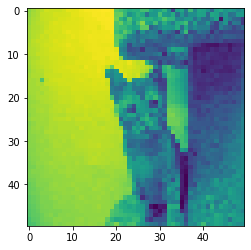

In [236]:
import matplotlib.pyplot as plt
plt.imshow(training_data[4000][0])
print(training_data[4000][1])
plt.show()

In [237]:
#we are done with processing training data and now we will build the model
import torch
torch.manual_seed(0)


import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5) #5 by 5 kernal size. This are two dimensional convolutional layers
        self.conv2 = nn.Conv2d(32,64,5) #5 by 5 kernal size 
        self.conv3 = nn.Conv2d(64,128,5) #5 by 5 kernal size 
     
        #How do we flattend the convolutional layer? The calculation is pretty interesting! 
        #Image Size, W =50, Kernel Size, k = 5, Stride , s = 1, Padding, P = 0
        #formula for conv2d is: { (W - k + 2*P)/s } + 1 = 46
        #Next, we apply a maxpool of size (2,2) hence reducing the size by half accross both dimensions of image
        #So o/p size after 1st maxpool layer = 46/2  = 23
        #formula for next conv2d is: { (W - k + 2*P)/s } + 1 = 19 =18 here we will take 18 as we can't represent pixels in decimal size
        #maxpool again = 18/2 = 9
        #formula for next conv2d gives us 5, we will take 4
        #maxpool final = 4/2 = 2
        # this gives us 2*2*128
    
        self.fc1 = nn.Linear(2*2*128,512) #128 comes from conv3
        self.fc2 = nn.Linear(512,2) #512 in and 2 output because there are two classes
       
        
        
    
    def forward(self,x):
        
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x,2,2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x,2,2)
            x = F.relu(self.conv3(x))
            x = F.max_pool2d(x,2,2)
            x = x.view(-1, 2*2*128)
            x = F.relu(self.fc1(x))
            x = self.fc2(x) #no activation needed for ouput layers
            return F.softmax(x, dim=1)
        
    
net = Net()
print(net)  

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [238]:
# We build the model and now we will declare optimizer and loss function
import torch.optim  as optim
optimizer = optim.Adam(net.parameters(), lr =.001) 
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/225.0  #scaling the image

y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT) #Validation set 10%
print(val_size)

2494


In [239]:
#Now we will split the training and test set using the validation percentage
#simple python indexing
train_X = X [:-val_size]
train_y = y [:-val_size]

test_X = X [-val_size:]
test_y = y [-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [240]:
# Time to pass training data and calculate loss
BATCH_SIZE = 100  #if we get memory error we can decrease the batch size
EPOCHS = 4

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):# from zero to the number of training size we are taking 100 inputs in each batch 
         
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            
            #next thing is to make the gradient zero as we want to actually iterate over this data to fit and test. 
            
            net.zero_grad()  #we could use optmizer.grad as well
            outputs = net(batch_X)
            
            # now we can calculate loss based on outputs and desried outputs, we have already declared loss function using mean square
            
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step() # Does the update
print(loss)            


100%|██████████| 225/225 [00:16<00:00, 14.04it/s]

100%|██████████| 225/225 [00:16<00:00, 13.45it/s]

100%|██████████| 225/225 [00:15<00:00, 14.15it/s]

100%|██████████| 225/225 [00:16<00:00, 13.63it/s]

tensor(0.1632, grad_fn=<MseLossBackward>)


In [241]:
#model is trained, we will find accuracy now. 
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total,3) )        


100%|██████████| 2494/2494 [00:02<00:00, 1237.81it/s]

Accuracy: 0.727
